In [1]:
import string

import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import re
import matplotlib.pyplot as plt

from ydata_profiling import ProfileReport
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk import tokenize
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold
from transformers import pipeline
%matplotlib inline

C:\Users\Andrii\anaconda3\envs\IASA-NLP-Homework\Lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
C:\Users\Andrii\anaconda3\envs\IASA-NLP-Homework\Lib\site-packages\visions\backends\shared\nan_handling.py:50: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @nb.jit


In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('brown')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Andrii\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andrii\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Andrii\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [3]:
prompts_train = pd.read_csv('./data/prompts_train.csv')
summaries_train = pd.read_csv('./data/summaries_train.csv')

**Dataset Description**
The dataset comprises about 24,000 summaries written by students in grades 3-12 of passages on a variety of topics and genres. These summaries have been assigned scores for both content and wording. The goal of the competition is to predict content and wording scores for summaries on unseen topics.

**File and Field Information**
`summaries_train.csv` - Summaries in the training set.
 - `student_id` - The ID of the student writer.
 - `prompt_id` - The ID of the prompt which links to the prompt file.
 - `text` - The full text of the student's summary.
 - `content` - The content score for the summary. The first target.
 - `wording` - The wording score for the summary. The second target.

`prompts_train.csv` - The four training set prompts. Each prompt comprises the complete summarization assignment given to students.
 - `prompt_id` - The ID of the prompt which links to the summaries file.
 - `prompt_question` - The specific question the students are asked to respond to.
 - `prompt_title` - A short-hand title for the prompt.
 - `prompt_text` - The full prompt text.

In [4]:
prompts_train.head()

prompt_id                                    prompt_question  \
0    39c16e  Summarize at least 3 elements of an ideal trag...   
1    3b9047  In complete sentences, summarize the structure...   
2    814d6b  Summarize how the Third Wave developed over su...   
3    ebad26  Summarize the various ways the factory would u...   

                prompt_title  \
0                 On Tragedy   
1  Egyptian Social Structure   
2             The Third Wave   
3    Excerpt from The Jungle   

                                         prompt_text  
0  Chapter 13 \r\nAs the sequel to what has alrea...  
1  Egyptian society was structured like a pyramid...  
2  Background \r\nThe Third Wave experiment took ...  
3  With one member trimming beef in a cannery, an...

In [5]:
summaries_train.head()

student_id prompt_id                                               text  \
0  000e8c3c7ddb    814d6b  The third wave was an experimentto see how peo...   
1  0020ae56ffbf    ebad26  They would rub it up with soda to make the sme...   
2  004e978e639e    3b9047  In Egypt, there were many occupations and soci...   
3  005ab0199905    3b9047  The highest class was Pharaohs these people we...   
4  0070c9e7af47    814d6b  The Third Wave developed  rapidly because the ...   

    content   wording  
0  0.205683  0.380538  
1 -0.548304  0.506755  
2  3.128928  4.231226  
3 -0.210614 -0.471415  
4  3.272894  3.219757

In [6]:
summaries_train.prompt_id.unique()

array(['814d6b', 'ebad26', '3b9047', '39c16e'], dtype=object)

In [7]:
summaries_train.dtypes

student_id     object
prompt_id      object
text           object
content       float64
wording       float64
dtype: object

In [8]:
summaries_train.student_id.value_counts()

student_id
000e8c3c7ddb    1
a9211e196f37    1
a9ba7154832d    1
a9ba1ad23b49    1
a9b02545f465    1
               ..
54f872b66565    1
54ec1d27bae3    1
54d3b82ff5b1    1
54ce5af681b0    1
fffbccfd8a08    1
Name: count, Length: 7165, dtype: int64

In [9]:
summaries_train.shape

(7165, 5)

# EDA

Firstly, we build report about all dataset

In [10]:
profile = ProfileReport(summaries_train, title="Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Then, we prepare out `summaries_train`, `prompts_train` to merge them. We encode `prompt_id` with unique indexes.

In [11]:
d = dict(list(zip(*pd.factorize(prompts_train.prompt_id)[::-1])))


def f(item):
    return d[item]

In [12]:
summaries_train['prompt_id_index'] = summaries_train['prompt_id'].transform(f)
summaries_train.head()

student_id prompt_id                                               text  \
0  000e8c3c7ddb    814d6b  The third wave was an experimentto see how peo...   
1  0020ae56ffbf    ebad26  They would rub it up with soda to make the sme...   
2  004e978e639e    3b9047  In Egypt, there were many occupations and soci...   
3  005ab0199905    3b9047  The highest class was Pharaohs these people we...   
4  0070c9e7af47    814d6b  The Third Wave developed  rapidly because the ...   

    content   wording  prompt_id_index  
0  0.205683  0.380538                2  
1 -0.548304  0.506755                3  
2  3.128928  4.231226                1  
3 -0.210614 -0.471415                1  
4  3.272894  3.219757                2

In [13]:
prompts_train['prompt_id_index'] = prompts_train['prompt_id'].transform(f)
prompts_train.head()

prompt_id                                    prompt_question  \
0    39c16e  Summarize at least 3 elements of an ideal trag...   
1    3b9047  In complete sentences, summarize the structure...   
2    814d6b  Summarize how the Third Wave developed over su...   
3    ebad26  Summarize the various ways the factory would u...   

                prompt_title  \
0                 On Tragedy   
1  Egyptian Social Structure   
2             The Third Wave   
3    Excerpt from The Jungle   

                                         prompt_text  prompt_id_index  
0  Chapter 13 \r\nAs the sequel to what has alrea...                0  
1  Egyptian society was structured like a pyramid...                1  
2  Background \r\nThe Third Wave experiment took ...                2  
3  With one member trimming beef in a cannery, an...                3

## Building word clouds

In [14]:
def build_world_cloud(serie):
    plt.figure(figsize=(20, 20))
    plt.title("Original Text")
    wc = WordCloud(max_words=500, width=800, height=400).generate(" ".join(serie))
    plt.imshow(wc, interpolation='bilinear')

Word cloud over all texts

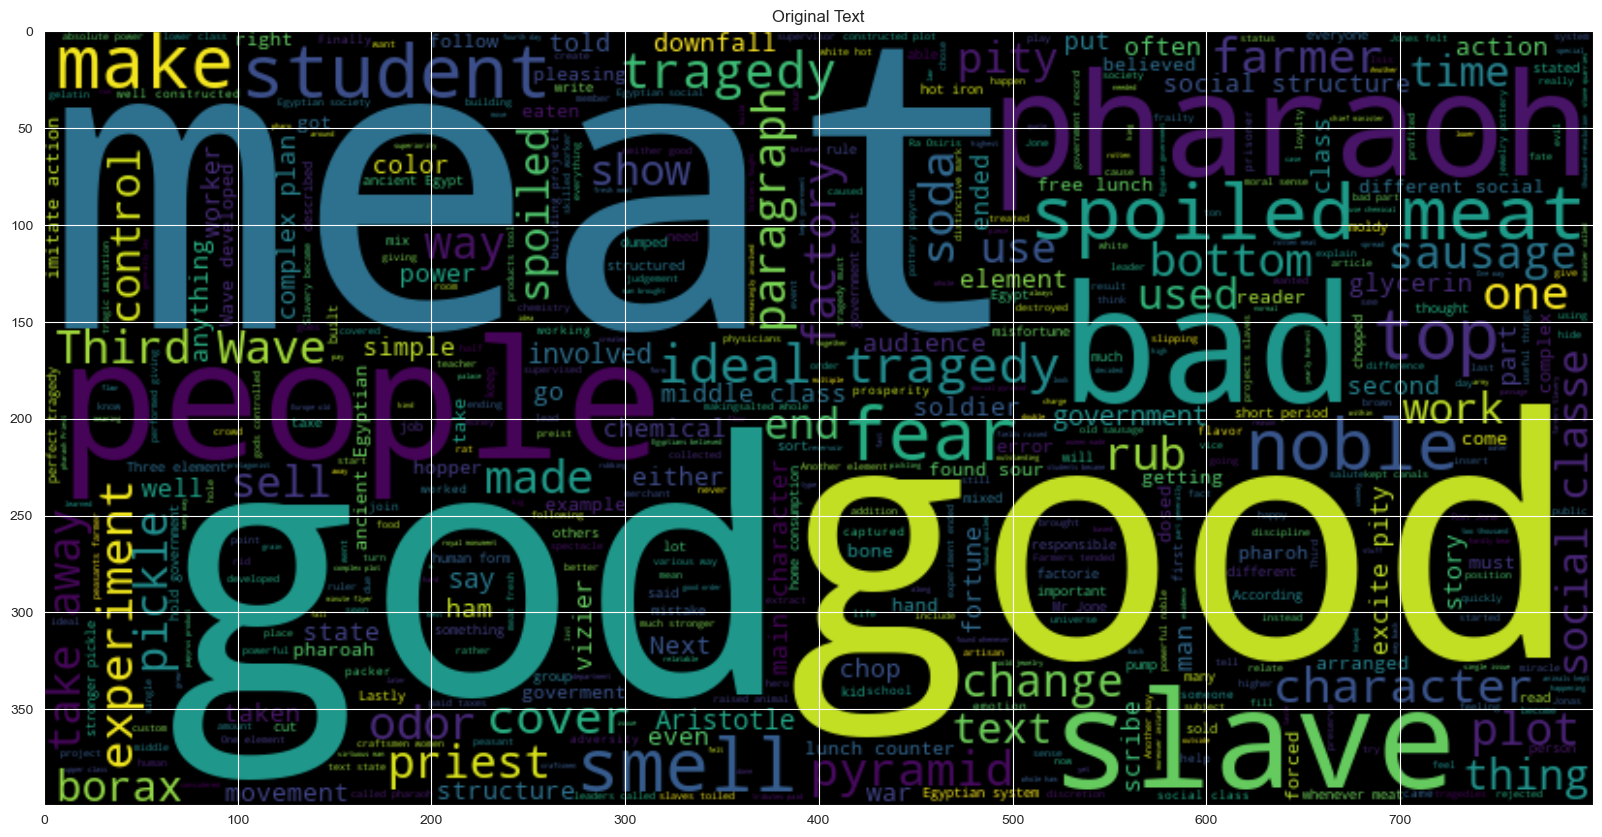

In [15]:
build_world_cloud(summaries_train['text'])

Word cloud over texts for the *On Tragedy* prompt

0    On Tragedy
Name: prompt_title, dtype: object


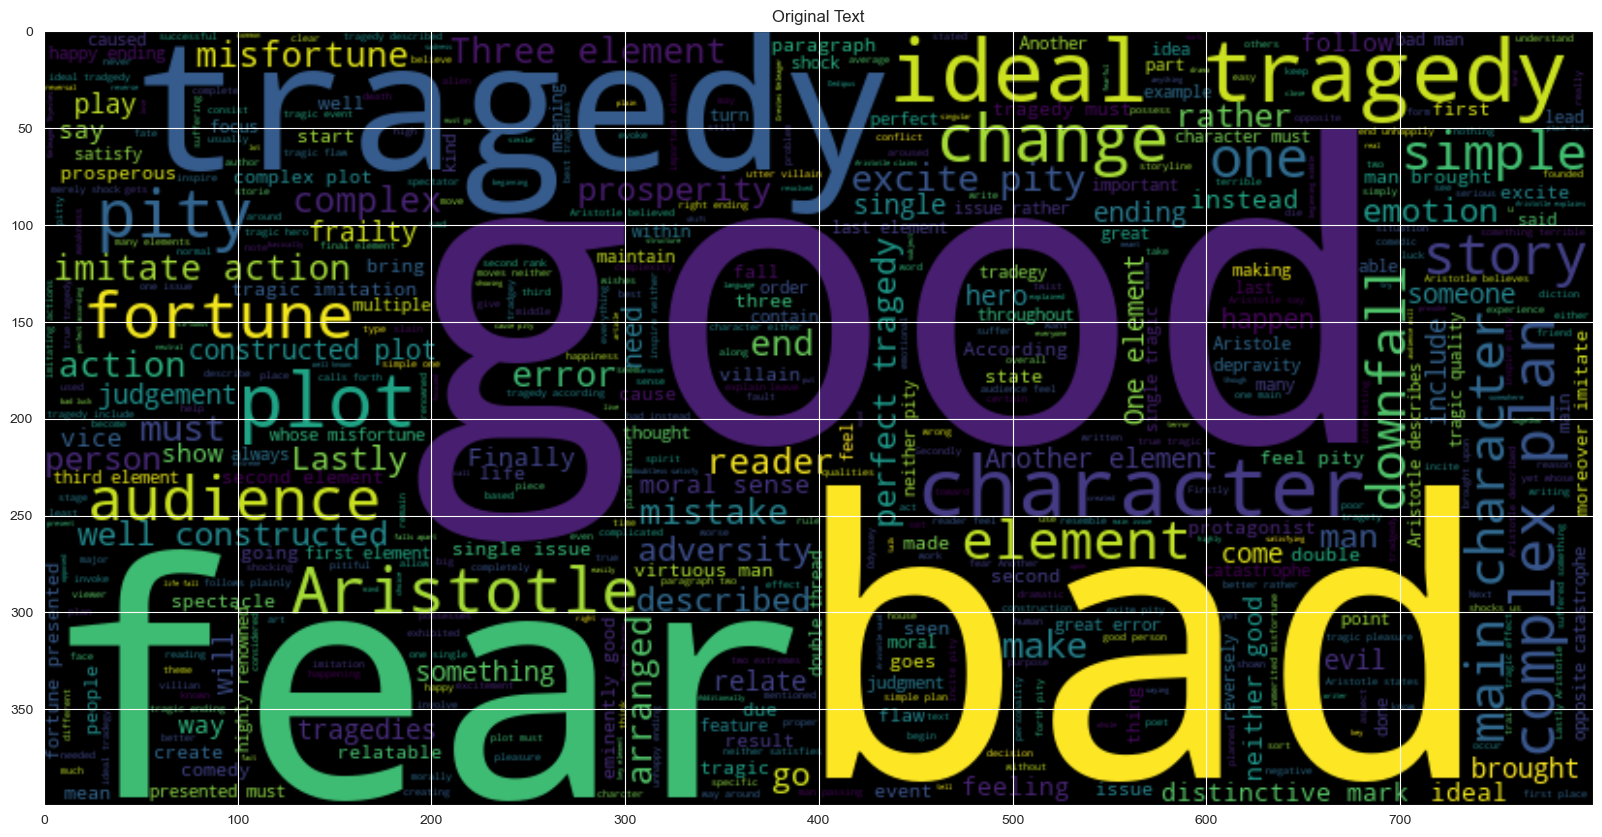

In [16]:
print(prompts_train[prompts_train['prompt_id_index'] == 0]['prompt_title'])
build_world_cloud(summaries_train[summaries_train['prompt_id_index'] == 0]['text'])

Word cloud over texts for the *Egyptian Social Structure* prompt

1    Egyptian Social Structure
Name: prompt_title, dtype: object


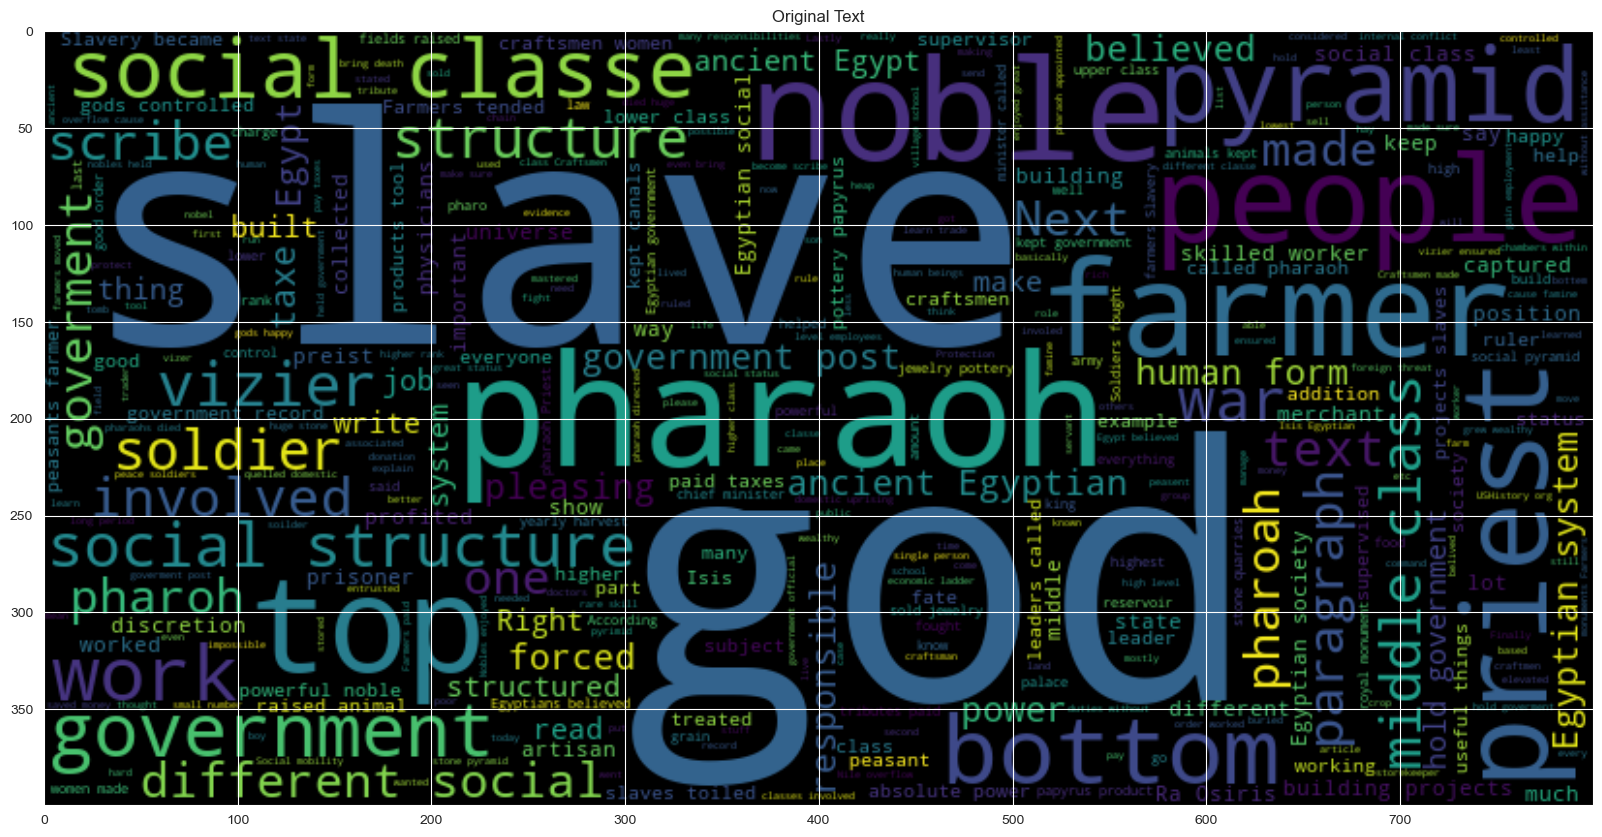

In [17]:
print(prompts_train[prompts_train['prompt_id_index'] == 1]['prompt_title'])
build_world_cloud(summaries_train[summaries_train['prompt_id_index'] == 1]['text'])

Word cloud over texts for the *The Third Wave* prompt

2    The Third Wave
Name: prompt_title, dtype: object


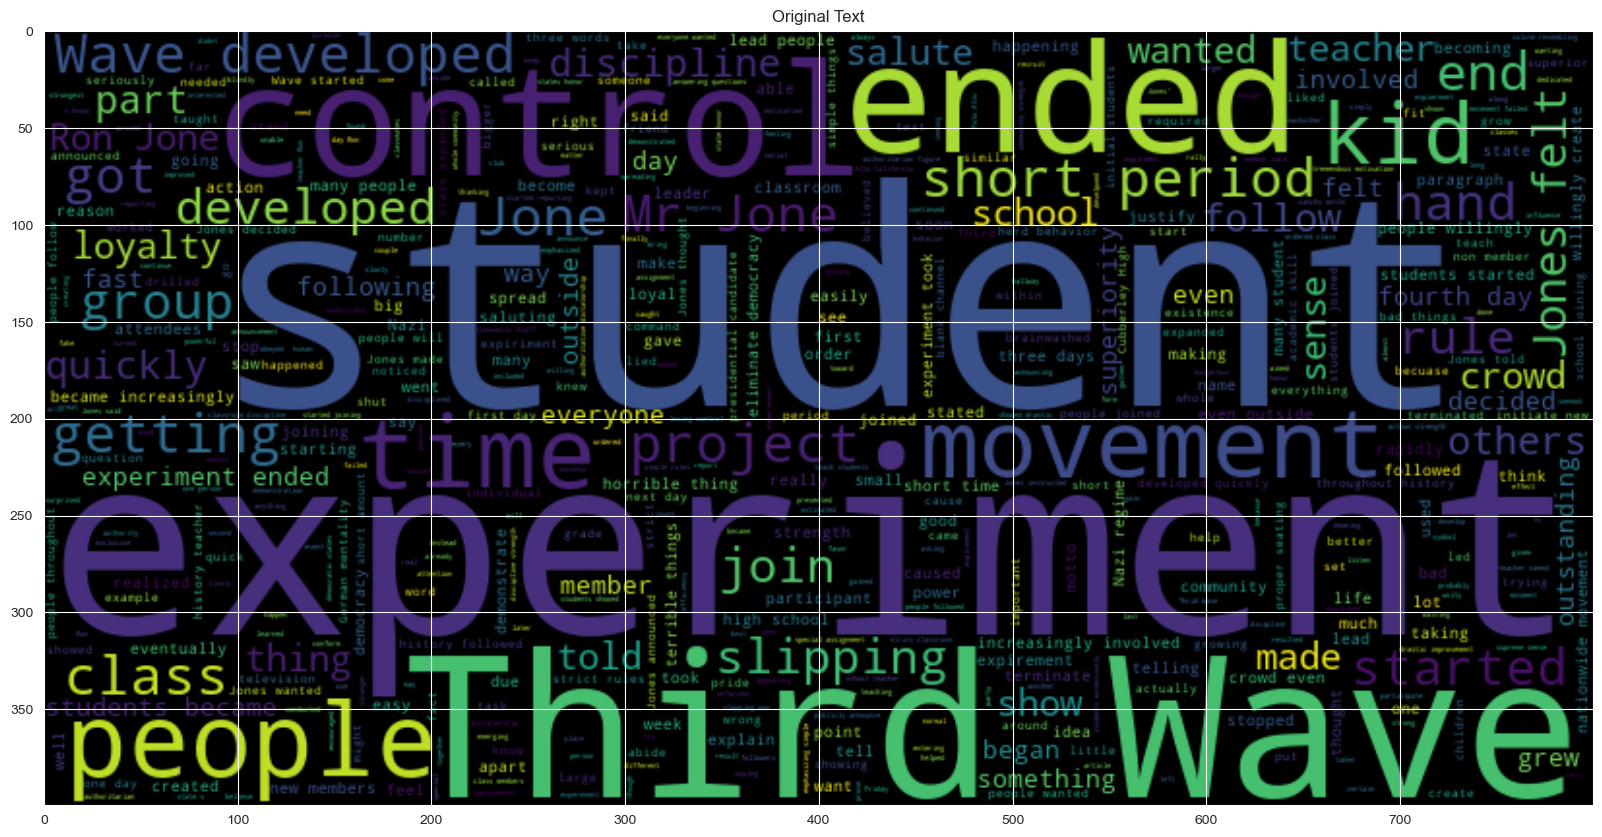

In [18]:
print(prompts_train[prompts_train['prompt_id_index'] == 2]['prompt_title'])
build_world_cloud(summaries_train[summaries_train['prompt_id_index'] == 2]['text'])

Word cloud over texts for the *Excerpt from The Jungle* prompt

3    Excerpt from The Jungle
Name: prompt_title, dtype: object


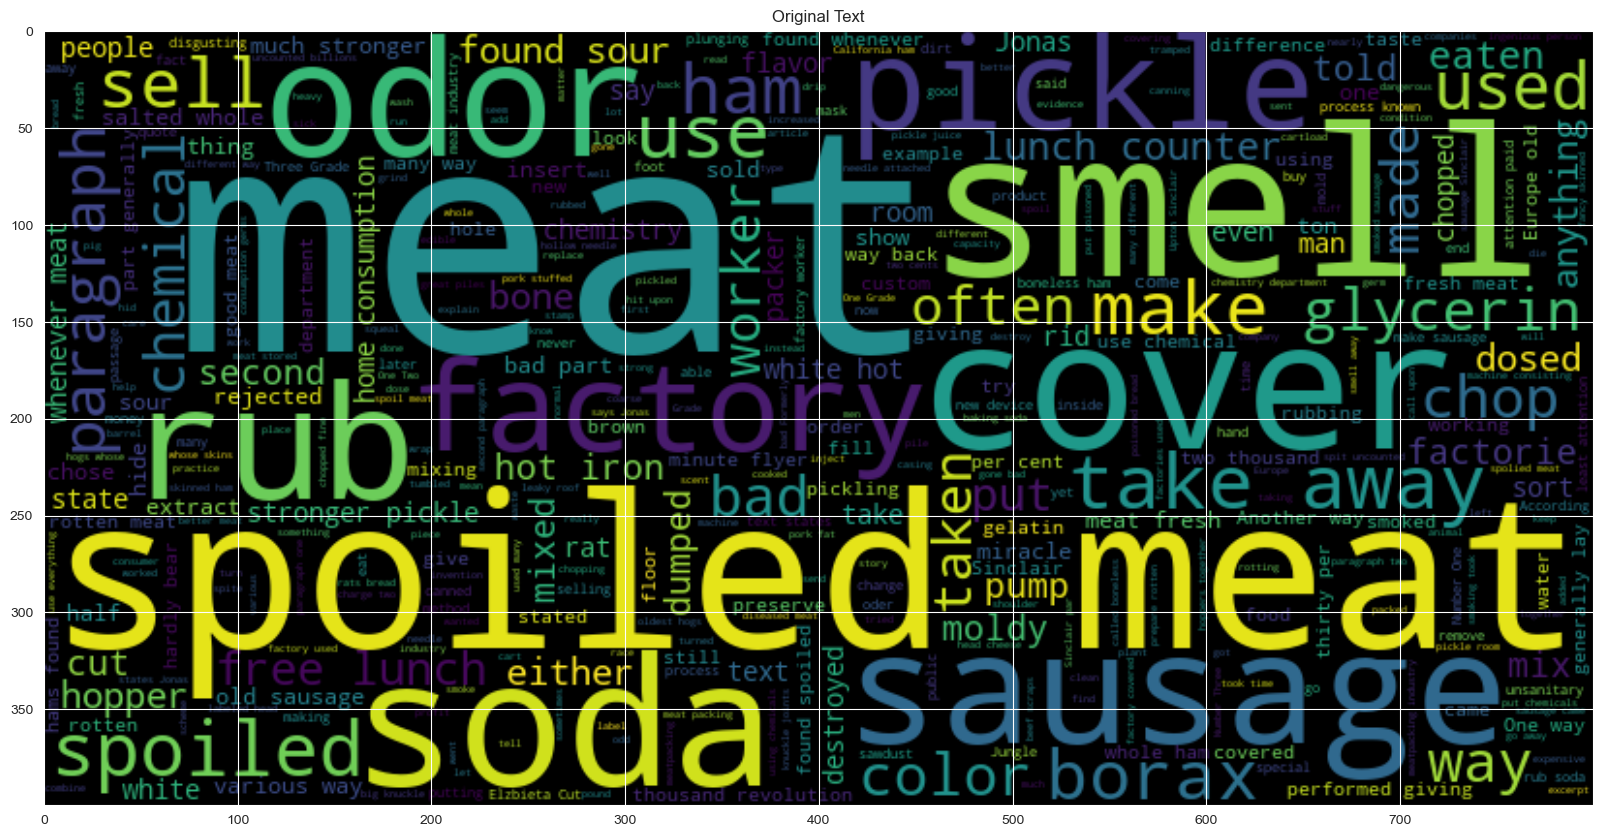

In [19]:
print(prompts_train[prompts_train['prompt_id_index'] == 3]['prompt_title'])
build_world_cloud(summaries_train[summaries_train['prompt_id_index'] == 3]['text'])

## Text preprocessing

Text cleaning function (remove all punctuation, make lowercase and delete stopwords, if needed)

In [20]:
def clear_text(text, stopwords=None):
    text = text.replace('\n', '').replace('\r', '').replace('\t', '')
    text = text.lower()
    text = re.sub(r"[^\w\s']+", '', text)

    if stopwords is not None:
        text = re.sub(rf'\b(?:{"|".join(stopwords)})\b', '', text)

    text = re.sub(rf'\s+', ' ', text)
    return text

Below is the function for building additional features.
Text features:
  - `clean_text`: text without all punctuation and made all to lowercase
  - `hard_clean_text`: as previous and delete all stopwords
  - `stem_clean_text`: stemmed clean text 
  - `stem_hard_clean_text`: stemmed clean text (delete all stop words)
  - `lem_clean_text`: lemmantized clean text
  - `lem_hard_clean_text`: lemmantized clean text(delete all stop words)
 
For stemming I use `nltk.stem.PorterStemmer`, and for lemmantizing I use `nltk.stem.WordNetLemmatizer`.

Numeric features:
  - `words_count`: the number of words in summary
  - `sentences_count`: the number of sentences in summary
  - `unique_words_count`: the number of unique words in summary
  - `stopwords_count`: the number of stopwords words in summary
  - `punkt_count`: the number of punctuation in summary
  - `char_count`: the total summary length in characters


In [21]:
def build_features(text):
    df = pd.DataFrame()
    df['text'] = text

    stop_words = stopwords.words('english')
    stemmer = nltk.stem.PorterStemmer()
    lemmatizer = nltk.stem.WordNetLemmatizer()

    df['clean_text'] = df['text'].apply(clear_text)  # clear all punctuation and make all to lowercase
    df['hard_clean_text'] = df['text'].apply(clear_text, args=(stop_words,))  # as previous and delete all stopwords

    df['stem_clean_text'] = df['clean_text'].apply(
        lambda x: ' '.join(stemmer.stem(token) for token in tokenize.word_tokenize(x))
    )
    df['stem_hard_clean_text'] = df['hard_clean_text'].apply(
        lambda x: ' '.join(stemmer.stem(token) for token in tokenize.word_tokenize(x))
    )

    df['lem_clean_text'] = df['clean_text'].apply(
        lambda x: ' '.join(lemmatizer.lemmatize(token) for token in tokenize.word_tokenize(x))
    )
    df['lem_hard_clean_text'] = df['hard_clean_text'].apply(
        lambda x: ' '.join(lemmatizer.lemmatize(token) for token in tokenize.word_tokenize(x))
    )

    df['words_count'] = df['text'].apply(
        lambda x: len(tokenize.word_tokenize(x))
    )  # count the number of words in the sentence
    df['sentences_count'] = df['text'].apply(
        lambda x: len(tokenize.sent_tokenize(x))
    )  # count the number of sentences in the sentence
    df['unique_words_count'] = df['clean_text'].apply(
        lambda x: len(set(tokenize.word_tokenize(x)))
    )  # count the number of unique words in the text
    df['stopwords_count'] = df['text'].apply(
        lambda x: len([w for w in tokenize.word_tokenize(x) if w in stop_words])
    )  # count the number of stop words in the text
    df['punkt_count'] = df['text'].apply(
        lambda x: len([c for c in str(x) if c in string.punctuation])
    )  # count the number of punctuation in the text
    df['char_count'] = df['clean_text'].apply(lambda x: len(x))  # count the length of the text in chars

    return df

Now we build all these additional features and... 

In [22]:
features = build_features(summaries_train['text'])
features.head()

text  \
0  The third wave was an experimentto see how peo...   
1  They would rub it up with soda to make the sme...   
2  In Egypt, there were many occupations and soci...   
3  The highest class was Pharaohs these people we...   
4  The Third Wave developed  rapidly because the ...   

                                          clean_text  \
0  the third wave was an experimentto see how peo...   
1  they would rub it up with soda to make the sme...   
2  in egypt there were many occupations and socia...   
3  the highest class was pharaohs these people we...   
4  the third wave developed rapidly because the s...   

                                     hard_clean_text  \
0   third wave experimentto see people reacted ne...   
1   would rub soda make smell go away wouldnt bad...   
2   egypt many occupations social classes involve...   
3   highest class pharaohs people godsthen 2nd hi...   
4   third wave developed rapidly students genuinl...   

                                     stem_clean_text  \
0  the third wave wa an experimentto see how peop...   
1  they would rub it up with soda to make the sme...   
2  in egypt there were mani occup and social clas...   
3  the highest class wa pharaoh these peopl were ...   
4  the third wave develop rapidli becaus the stud...   

                                stem_hard_clean_text  \
0  third wave experimentto see peopl react new on...   
1  would rub soda make smell go away wouldnt bad ...   
2  egypt mani occup social class involv daytoday ...   
3  highest class pharaoh peopl godsthen 2nd highe...   
4  third wave develop rapidli student genuinli be...   

                                      lem_clean_text  \
0  the third wave wa an experimentto see how peop...   
1  they would rub it up with soda to make the sme...   
2  in egypt there were many occupation and social...   
3  the highest class wa pharaoh these people were...   
4  the third wave developed rapidly because the s...   

                                 lem_hard_clean_text  words_count  \
0  third wave experimentto see people reacted new...           64   
1  would rub soda make smell go away wouldnt bad ...           54   
2  egypt many occupation social class involved da...          269   
3  highest class pharaoh people godsthen 2nd high...           28   
4  third wave developed rapidly student genuinly ...          232   

   sentences_count  unique_words_count  stopwords_count  punkt_count  \
0                4                  49               21            3   
1                2                  35               29            2   
2               12                 138               92           38   
3                2                  18               10            6   
4               14                 128               81           30   

   char_count  
0         343  
1         242  
2        1334  
3         151  
4        1194

make the finale data frame, witch would be used in modeling section.

In [23]:
df = pd.concat([features, summaries_train[['content', 'wording', 'prompt_id_index']]], axis=1)
df

text  \
0     The third wave was an experimentto see how peo...   
1     They would rub it up with soda to make the sme...   
2     In Egypt, there were many occupations and soci...   
3     The highest class was Pharaohs these people we...   
4     The Third Wave developed  rapidly because the ...   
...                                                 ...   
7160  They used all sorts of chemical concoctions to...   
7161  The lowest classes are slaves and farmers slav...   
7162             they sorta made people start workin...   
7163  An ideal tragety has three elements that make ...   
7164  The meat would smell sour but the would "rub i...   

                                             clean_text  \
0     the third wave was an experimentto see how peo...   
1     they would rub it up with soda to make the sme...   
2     in egypt there were many occupations and socia...   
3     the highest class was pharaohs these people we...   
4     the third wave developed rapidly because the s...   
...                                                 ...   
7160  they used all sorts of chemical concoctions to...   
7161  the lowest classes are slaves and farmers slav...   
7162   they sorta made people start working on the s...   
7163  an ideal tragety has three elements that make ...   
7164  the meat would smell sour but the would rub it...   

                                        hard_clean_text  \
0      third wave experimentto see people reacted ne...   
1      would rub soda make smell go away wouldnt bad...   
2      egypt many occupations social classes involve...   
3      highest class pharaohs people godsthen 2nd hi...   
4      third wave developed rapidly students genuinl...   
...                                                 ...   
7160   used sorts chemical concoctions make meat see...   
7161   lowest classes slaves farmers slaves people t...   
7162   sorta made people start working structour the...   
7163   ideal tragety three elements make ideal start...   
7164   meat would smell sour would rub soda take awa...   

                                        stem_clean_text  \
0     the third wave wa an experimentto see how peop...   
1     they would rub it up with soda to make the sme...   
2     in egypt there were mani occup and social clas...   
3     the highest class wa pharaoh these peopl were ...   
4     the third wave develop rapidli becaus the stud...   
...                                                 ...   
7160  they use all sort of chemic concoct to make th...   
7161  the lowest class are slave and farmer slave be...   
7162  they sorta made peopl start work on the struct...   
7163  an ideal trageti ha three element that make it...   
7164  the meat would smell sour but the would rub it...   

                                   stem_hard_clean_text  \
0     third wave experimentto see peopl react new on...   
1     would rub soda make smell go away wouldnt bad ...   
2     egypt mani occup social class involv daytoday ...   
3     highest class pharaoh peopl godsthen 2nd highe...   
4     third wave develop rapidli student genuinli be...   
...                                                 ...   
7160  use sort chemic concoct make meat seem fine sh...   
7161  lowest class slave farmer slave peopl taken wa...   
7162  sorta made peopl start work structour they bar...   
7163  ideal trageti three element make ideal start g...   
7164  meat would smell sour would rub soda take away...   

                                         lem_clean_text  \
0     the third wave wa an experimentto see how peop...   
1     they would rub it up with soda to make the sme...   
2     in egypt there were many occupation and social...   
3     the highest class wa pharaoh these people were...   
4     the third wave developed rapidly because the s...   
...                                                 ...   
7160  they used all sort of chemical concoction to m...   
7161  the lowest class are slave a

Also, we build correlation matrix between numeric features and targets.

<Axes: >

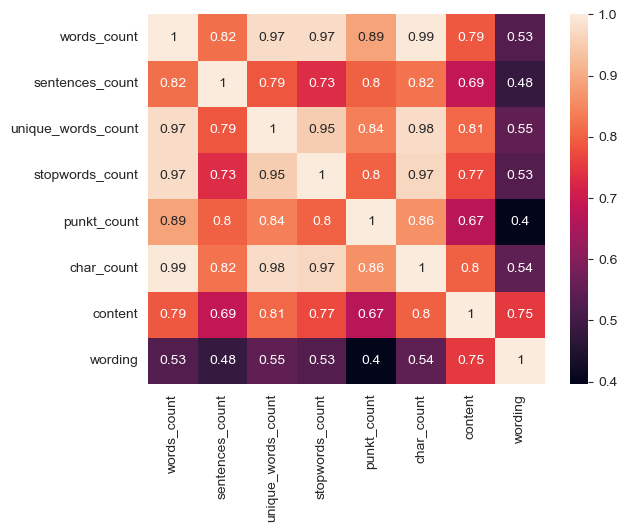

In [24]:
corr = df.iloc[:, -9:-1].corr()
sns.heatmap(corr, annot=True)

# Modeling

Below is the function, witch takes a pipeline, metric and folder and evaluate the quality of this pipeline on this metric based on cross-validation principal.

In [25]:
def evaluate_pipeline(pipeline, metric, folder):
    all_train_preds = []
    all_test_preds = []
    all_train_targets = []
    all_test_targets = []

    for fold_id, (train_ids, test_ids) in enumerate(folder):
        pipeline_, X_train, X_test, y_train, y_test = pipeline(train_ids, test_ids)

        pipeline_.fit(X_train, y_train)

        fold_train_preds = pipeline_.predict(X_train)
        fold_test_preds = pipeline_.predict(X_test)

        fold_train_targets = y_train.to_numpy()
        fold_test_targets = y_test.to_numpy()

        all_train_preds.append(fold_train_preds)
        all_test_preds.append(fold_test_preds)
        all_train_targets.append(fold_train_targets)
        all_test_targets.append(fold_test_targets)

    all_train_preds = np.concatenate(all_train_preds)
    all_test_preds = np.concatenate(all_test_preds)
    all_train_targets = np.concatenate(all_train_targets)
    all_test_targets = np.concatenate(all_test_targets)

    print(f"\nOOF Train Score: {metric(all_train_targets, all_train_preds)}")
    print(f"OOF Test Score: {metric(all_test_targets, all_test_preds)}")
    return metric(all_test_targets, all_test_preds)

## Bag-of-words and TF-IDF

Next, I build a pipeline fabric function for all models, based on bag-of-words and tf-idf vectorizers

In [26]:
def make_pipeline(model, vectorizer, data, labels):
    def _pipeline(train_ids, test_ids):
        pipeline_ = Pipeline(
            [
                ('vect', vectorizer[0](*vectorizer[1], **vectorizer[2])),
                ('model', model[0](*model[1], **model[2]))
            ]
        )
        X_train, X_test = data.iloc[train_ids], data.iloc[test_ids]
        y_train, y_test = labels.iloc[train_ids], labels.iloc[test_ids]
        return pipeline_, X_train, X_test, y_train, y_test

    return _pipeline

Importing all models and vectorizers witch combination we will evaluate.
Also, making aliases for data (we will only predict `wording` using `clean_text`).

In [27]:
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge, ElasticNet, LinearRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

X, y, grouping = df['clean_text'], df['wording'], df['prompt_id_index']

Below is the code for evaluating all pairs of vectorizer and model

In [28]:
from itertools import product

models = (Ridge, ElasticNet, LinearRegression)
vectorizers = (CountVectorizer, TfidfVectorizer)
results = {}
for model, vectorizer in product(models, vectorizers):
    error = \
        evaluate_pipeline(
            make_pipeline(
                (model, (), {}),
                (vectorizer, (), {'stop_words': []}),
                X, y,
            ),
            mean_absolute_error,
            GroupKFold(4).split(X, y, grouping)
        )
    results[f'Model: {model.__name__}, Vectorizer: {vectorizer.__name__}'] = error
results


OOF Train Score: 0.17397887779621019
OOF Test Score: 0.9458585893619412

OOF Train Score: 0.4072628539942748
OOF Test Score: 0.8315941096174543

OOF Train Score: 0.7272208280551181
OOF Test Score: 0.7698487228708146

OOF Train Score: 0.8245960597269092
OOF Test Score: 0.8425183447062122

OOF Train Score: 0.006922523407333208
OOF Test Score: 4.710034230680768

OOF Train Score: 0.002765292662776943
OOF Test Score: 9.237819315857122


{'Model: Ridge, Vectorizer: CountVectorizer': 0.9458585893619412,
 'Model: Ridge, Vectorizer: TfidfVectorizer': 0.8315941096174543,
 'Model: ElasticNet, Vectorizer: CountVectorizer': 0.7698487228708146,
 'Model: ElasticNet, Vectorizer: TfidfVectorizer': 0.8425183447062122,
 'Model: LinearRegression, Vectorizer: CountVectorizer': 4.710034230680768,
 'Model: LinearRegression, Vectorizer: TfidfVectorizer': 9.237819315857122}

As we see the best result is obtained in pair (`CountVectorizer`, `ElasticNet`). 
Next we will look for the best parameters for this pair using `GridSearchCV`.

In [29]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline(
    [
        ('vect', CountVectorizer()),
        ('clf', ElasticNet()),
    ]
)

search_space = [{
    'vect__stop_words': (None, []),
    'vect__ngram_range': ((1, 1),),
    'clf__alpha': [0.01, 0.1, 1, 10],
    'clf__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}]

# Create grid search 
clf = GridSearchCV(
    pipeline,
    search_space,
    cv=GroupKFold(4).split(X, y, df['prompt_id_index']),
    verbose=2,
    n_jobs=-1,
    scoring='neg_mean_absolute_error'
)

# Fit grid search
clf.fit(X, y)
clf.best_params_, clf.best_score_

Fitting 4 folds for each of 40 candidates, totalling 160 fits


({'clf__alpha': 1,
  'clf__l1_ratio': 0.1,
  'vect__ngram_range': (1, 1),
  'vect__stop_words': None},
 -0.7808109407016092)

Here we have best parameters and the best score (0.7808) for this pair in task of predicting `wording` target

## Word2Vec and GloVe

Further, we wil train models based on sentence embeddings.
Sentence embeddings we will form as mean or sum of the word embeddings of this sentence.

In [30]:
from contextlib import redirect_stdout, contextmanager
import os


@contextmanager
def suppress():
    with open(os.devnull, "w") as null:
        with redirect_stdout(null):
            yield

In [31]:
import gensim
import gensim.downloader as api

api.info()['models'].keys()

dict_keys(['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis'])

Download two, the most popular, embeddings dictionaries: Word2Vec and GloVe.

In [32]:
with suppress():
    word2vec_model = api.load("word2vec-google-news-300")
    glove_model = api.load("glove-wiki-gigaword-300")

As previous, we define the fabric function for all models, based on sentence embeddings.

In [33]:
def make_pipeline(model, vectorizer, data, labels, aggregation_function):
    def _pipeline(train_ids, test_ids):
        pipeline_ = model()
        X_train, X_test = data.iloc[train_ids], data.iloc[test_ids]

        X_train = [
            aggregation_function(
                [
                    vectorizer[token] for token in tokenize.word_tokenize(el) if token in vectorizer
                ],
                axis=0
            ).reshape(1, -1) for el in X_train
        ]
        X_train = np.concatenate(X_train, axis=0)

        X_test = [
            aggregation_function(
                [
                    vectorizer[token] for token in tokenize.word_tokenize(el) if token in vectorizer
                ],
                axis=0
            ).reshape(1, -1) for el in X_test
        ]
        X_test = np.concatenate(X_test, axis=0)

        y_train, y_test = labels.iloc[train_ids], labels.iloc[test_ids]
        return pipeline_, X_train, X_test, y_train, y_test

    return _pipeline

This code implements the algorithm for finding the best pair (`text column`, `vectorization model`) for each target, with two types of sentence embeddings formation (np.mean, np.sum)

In [34]:
from itertools import product

columns = ('clean_text', 'hard_clean_text', 'stem_clean_text',
           'stem_hard_clean_text', 'lem_clean_text', 'lem_hard_clean_text')
word2vec_model.name = 'word2vec_model'
glove_model.name = 'glove_model'
vectorizers = (word2vec_model, glove_model)
targets = ('wording', 'content')

In [35]:
results = {}
for column, vectorizer, target in product(columns, vectorizers, targets):
    error = \
        evaluate_pipeline(
            make_pipeline(
                ElasticNet,
                vectorizer,
                df[column], df[target],
                np.mean
            ),
            mean_absolute_error,
            GroupKFold(4).split(df[column], df[target], grouping),
        )
    results[f'Column: {column}, Vectorizer: {vectorizer.name}, Target: {target}'] = error
results


OOF Train Score: 0.8245960599652821
OOF Test Score: 0.8425183459258422

OOF Train Score: 0.8175362765239123
OOF Test Score: 0.8191831979289143

OOF Train Score: 0.8245960599652821
OOF Test Score: 0.8425183459258422

OOF Train Score: 0.8175362765239123
OOF Test Score: 0.8191831979289143

OOF Train Score: 0.8245960599652821
OOF Test Score: 0.8425183459258422

OOF Train Score: 0.8175362765239123
OOF Test Score: 0.8191831979289143

OOF Train Score: 0.8245960599652821
OOF Test Score: 0.8425183459258422

OOF Train Score: 0.8175362765239123
OOF Test Score: 0.8191831979289143

OOF Train Score: 0.8245960599652821
OOF Test Score: 0.8425183459258422

OOF Train Score: 0.8175362765239123
OOF Test Score: 0.8191831979289143

OOF Train Score: 0.8245960599652821
OOF Test Score: 0.8425183459258422

OOF Train Score: 0.8175362765239123
OOF Test Score: 0.8191831979289143

OOF Train Score: 0.8245960599652821
OOF Test Score: 0.8425183459258422

OOF Train Score: 0.8175362765239123
OOF Test Score: 0.819183197

{'Column: clean_text, Vectorizer: word2vec_model, Target: wording': 0.8425183459258422,
 'Column: clean_text, Vectorizer: word2vec_model, Target: content': 0.8191831979289143,
 'Column: clean_text, Vectorizer: glove_model, Target: wording': 0.8425183459258422,
 'Column: clean_text, Vectorizer: glove_model, Target: content': 0.8191831979289143,
 'Column: hard_clean_text, Vectorizer: word2vec_model, Target: wording': 0.8425183459258422,
 'Column: hard_clean_text, Vectorizer: word2vec_model, Target: content': 0.8191831979289143,
 'Column: hard_clean_text, Vectorizer: glove_model, Target: wording': 0.8425183459258422,
 'Column: hard_clean_text, Vectorizer: glove_model, Target: content': 0.8191831979289143,
 'Column: stem_clean_text, Vectorizer: word2vec_model, Target: wording': 0.8425183459258422,
 'Column: stem_clean_text, Vectorizer: word2vec_model, Target: content': 0.8191831979289143,
 'Column: stem_clean_text, Vectorizer: glove_model, Target: wording': 0.8425183459258422,
 'Column: st

As we see abow there is no matter what column and vectorizer to use in case when we average word embeddings.
We have next result:
 - wording: 0.8425
  - content: 0.8192

In [36]:
results = {}
for column, vectorizer, target in product(columns, vectorizers, targets):
    error = \
        evaluate_pipeline(
            make_pipeline(
                ElasticNet,
                vectorizer,
                df[column], df[target],
                np.sum
            ),
            mean_absolute_error,
            GroupKFold(4).split(df[column], df[target], grouping),
        )
    results[f'Column: {column}, Vectorizer: {vectorizer.name}, Target: {target}'] = error
results


OOF Train Score: 0.668089575353019
OOF Test Score: 0.7096593603111182

OOF Train Score: 0.4947890255153888
OOF Test Score: 0.5572059914066401

OOF Train Score: 0.6567002681104365
OOF Test Score: 0.7119833129575733

OOF Train Score: 0.4744723033342676
OOF Test Score: 0.49403292536410476

OOF Train Score: 0.6894969535348171
OOF Test Score: 0.7526019030459337

OOF Train Score: 0.5191083984677366
OOF Test Score: 0.5995888455842805

OOF Train Score: 0.6533407878839294
OOF Test Score: 0.7164356848399805

OOF Train Score: 0.4810725169957655
OOF Test Score: 0.5142958401679742

OOF Train Score: 0.6847969006120956
OOF Test Score: 0.7652578120601399

OOF Train Score: 0.5140481070657201
OOF Test Score: 0.5674051576355597

OOF Train Score: 0.6668869628136462
OOF Test Score: 0.7347922954829691

OOF Train Score: 0.4807612369758167
OOF Test Score: 0.5001725117101834

OOF Train Score: 0.7172581132088847
OOF Test Score: 0.7701474283171151

OOF Train Score: 0.5600704369022077
OOF Test Score: 0.620950310

{'Column: clean_text, Vectorizer: word2vec_model, Target: wording': 0.7096593603111182,
 'Column: clean_text, Vectorizer: word2vec_model, Target: content': 0.5572059914066401,
 'Column: clean_text, Vectorizer: glove_model, Target: wording': 0.7119833129575733,
 'Column: clean_text, Vectorizer: glove_model, Target: content': 0.49403292536410476,
 'Column: hard_clean_text, Vectorizer: word2vec_model, Target: wording': 0.7526019030459337,
 'Column: hard_clean_text, Vectorizer: word2vec_model, Target: content': 0.5995888455842805,
 'Column: hard_clean_text, Vectorizer: glove_model, Target: wording': 0.7164356848399805,
 'Column: hard_clean_text, Vectorizer: glove_model, Target: content': 0.5142958401679742,
 'Column: stem_clean_text, Vectorizer: word2vec_model, Target: wording': 0.7652578120601399,
 'Column: stem_clean_text, Vectorizer: word2vec_model, Target: content': 0.5674051576355597,
 'Column: stem_clean_text, Vectorizer: glove_model, Target: wording': 0.7347922954829691,
 'Column: s

In case of using `np.sum` as aggregation function to form sentence embedding, we have next best results:
 - wording: 0.7096 (`clean_text` and `word2vec_model`)
  - content: 0.494 (`clean_text` and `glove_model`) and 0.496 (`lem_clean_text` and `glove_model`)

In [37]:
X = [
    np.sum(
        [
            glove_model[token] for token in tokenize.word_tokenize(el) if token in glove_model
        ],
        axis=0
    ).reshape(1, -1) for el in df['clean_text']
]
X = np.concatenate(X, axis=0)

In [38]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline(
    [
        ('clf', ElasticNet()),
    ]
)

# Create space of candidate learning algorithms and their hyperparameters
search_space = [{
    'clf__alpha': [0.001, 0.01, 0.1, 1, 10],
    'clf__tol': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5],
    'clf__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
}]
y = df['wording']
# Create grid search 
clf = GridSearchCV(
    pipeline,
    search_space,
    cv=GroupKFold(4).split(X, y, df['prompt_id_index']),
    verbose=1,
    n_jobs=-1,
    scoring='neg_mean_absolute_error'
)

# Fit grid search
clf.fit(X, y)
clf.best_params_, clf.best_score_

Fitting 4 folds for each of 125 candidates, totalling 500 fits


({'clf__alpha': 1, 'clf__l1_ratio': 0.1, 'clf__tol': 0.01}, -0.722864852324913)

In [39]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline(
    [
        ('clf', ElasticNet()),
    ]
)

# Create space of candidate learning algorithms and their hyperparameters
search_space = [{
    'clf__alpha': [0.001, 0.01, 0.1, 1, 10],
    'clf__tol': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5],
    'clf__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
}]
y = df['content']
# Create grid search 
clf = GridSearchCV(
    pipeline,
    search_space,
    cv=GroupKFold(4).split(X, y, df['prompt_id_index']),
    verbose=1,
    n_jobs=-1,
    scoring='neg_mean_absolute_error'
)

# Fit grid search
clf.fit(X, y)
clf.best_params_, clf.best_score_

Fitting 4 folds for each of 125 candidates, totalling 500 fits


({'clf__alpha': 1, 'clf__l1_ratio': 0.5, 'clf__tol': 0.01},
 -0.49366026373166216)

## SentenceTransformer

Now, we will try to use a `SentenceTransformer` class to form sentence embeddings. We will use the best model, witch is available in this library `all-mpnet-base-v2`.

In [40]:
from sentence_transformers import SentenceTransformer

former = SentenceTransformer('all-mpnet-base-v2', device="cuda")

Below, we define the fabric function for all models, based on `SentenceTransformer`. Note, that now we will use `prompt_train` data to get better results.

In [41]:
def make_pipeline(model, former, text, data, prompts, labels):
    for prompt in prompts:
        prompt_ = prompt.copy()
        prompt_.iloc[:, 0] = prompt_.iloc[:, 0].apply(lambda x: former.encode(x).reshape((1, -1)))
        data = data.merge(prompt_, on='prompt_id_index', how='left')

    prompts = []
    for encoded_prompt in data.iloc[:, 2:]:
        prompts.append(np.concatenate(data[encoded_prompt].to_numpy()))

    X = np.concatenate([text] + prompts, axis=1)

    def _pipeline(train_ids, test_ids):
        pipeline_ = model()

        X_train, X_test = X[train_ids], X[test_ids]
        y_train, y_test = labels.iloc[train_ids], labels.iloc[test_ids]

        return pipeline_, X_train, X_test, y_train, y_test

    return _pipeline

Further, we build all combination of `prompt_text`, `prompt_title`, `prompt_question`.

In [42]:
from itertools import combinations

my_list = [
    prompts_train[['prompt_text', 'prompt_id_index']],
    prompts_train[['prompt_title', 'prompt_id_index']],
    prompts_train[['prompt_question', 'prompt_id_index']]
]
prompts = []
for r in range(1, len(my_list) + 1):
    for combo in combinations(my_list, r):
        prompts.append(combo)

Then, we want to find the best combination of `columns`, `models`, `prompts` for each target

In [43]:
columns = ('text', 'clean_text', 'hard_clean_text', 'stem_clean_text',
           'stem_hard_clean_text', 'lem_clean_text', 'lem_hard_clean_text')
models = (ElasticNet, Ridge)

targets = ('content', 'wording')

In [44]:
results = {}
for column in columns:
    text = former.encode(df[column].tolist(), batch_size=32)
    for model, prompt, target in product(models, prompts, targets):
    
        error = \
            evaluate_pipeline(
                make_pipeline(
                    model,
                    former,
                    text,
                    df[[column, 'prompt_id_index']],
                    prompt,
                    df[target],
                ),
                mean_absolute_error,
                GroupKFold(4).split(df[column], df[target], df['prompt_id_index']),
            )
        results[f'Column: {column}, model: {model.__name__}, prompt: {[prompt_.columns[0] for prompt_ in prompt]}, target: {target}'] = error
results


OOF Train Score: 0.8175362765239123
OOF Test Score: 0.8191831979289143

OOF Train Score: 0.8245960599652821
OOF Test Score: 0.8425183459258422

OOF Train Score: 0.8175362765239123
OOF Test Score: 0.8191831979289143

OOF Train Score: 0.8245960599652821
OOF Test Score: 0.8425183459258422

OOF Train Score: 0.8175362765239123
OOF Test Score: 0.8191831979289143

OOF Train Score: 0.8245960599652821
OOF Test Score: 0.8425183459258422

OOF Train Score: 0.8175362765239123
OOF Test Score: 0.8191831979289143

OOF Train Score: 0.8245960599652821
OOF Test Score: 0.8425183459258422

OOF Train Score: 0.8175362765239123
OOF Test Score: 0.8191831979289143

OOF Train Score: 0.8245960599652821
OOF Test Score: 0.8425183459258422

OOF Train Score: 0.8175362765239123
OOF Test Score: 0.8191831979289143

OOF Train Score: 0.8245960599652821
OOF Test Score: 0.8425183459258422

OOF Train Score: 0.8175362765239123
OOF Test Score: 0.8191831979289143

OOF Train Score: 0.8245960599652821
OOF Test Score: 0.842518345

{"Column: text, model: ElasticNet, prompt: ['prompt_text'], target: content": 0.8191831979289143,
 "Column: text, model: ElasticNet, prompt: ['prompt_text'], target: wording": 0.8425183459258422,
 "Column: text, model: ElasticNet, prompt: ['prompt_title'], target: content": 0.8191831979289143,
 "Column: text, model: ElasticNet, prompt: ['prompt_title'], target: wording": 0.8425183459258422,
 "Column: text, model: ElasticNet, prompt: ['prompt_question'], target: content": 0.8191831979289143,
 "Column: text, model: ElasticNet, prompt: ['prompt_question'], target: wording": 0.8425183459258422,
 "Column: text, model: ElasticNet, prompt: ['prompt_text', 'prompt_title'], target: content": 0.8191831979289143,
 "Column: text, model: ElasticNet, prompt: ['prompt_text', 'prompt_title'], target: wording": 0.8425183459258422,
 "Column: text, model: ElasticNet, prompt: ['prompt_text', 'prompt_question'], target: content": 0.8191831979289143,
 "Column: text, model: ElasticNet, prompt: ['prompt_text'

In [45]:
min_key = None
min_value = np.inf
for key in results.keys():
    if 'wording' in key:
        if results[key] < min_value:
            min_value = results[key]
        min_key = key
        
min_value, min_key

(0.7840769366290863,
 "Column: lem_hard_clean_text, model: Ridge, prompt: ['prompt_text', 'prompt_title', 'prompt_question'], target: wording")

In [46]:
min_key = None
min_value = np.inf
for key in results.keys():
    if 'content' in key:
        if results[key] < min_value:
            min_value = results[key]
        min_key = key

min_value, min_key

(0.8148179379671411,
 "Column: lem_hard_clean_text, model: Ridge, prompt: ['prompt_text', 'prompt_title', 'prompt_question'], target: content")

As we, for both `wording` and `content` the best combination is:
Column: `lem_hard_clean_text`, model: `Ridge`, prompt: [`prompt_text`, `prompt_title`, `prompt_question`]


After this, I will tune hyper parameters for `Ridge` model for each target (`wording`, `content`)

In [47]:
prompt = prompts_train.copy()
prompt['prompt_question'] = prompt['prompt_question'].apply(lambda x: former.encode(x).reshape(1, -1))
prompt['prompt_text'] = prompt['prompt_text'].apply(lambda x: former.encode(x).reshape(1, -1))
prompt['prompt_title'] = prompt['prompt_title'].apply(lambda x: former.encode(x).reshape(1, -1))
prompt1 = np.concatenate(
    df.merge(prompt, on='prompt_id_index', how='left')['prompt_question'].tolist(), axis=0
)
prompt2 = np.concatenate(
    df.merge(prompt, on='prompt_id_index', how='left')['prompt_text'].tolist(), axis=0
)
prompt3 = np.concatenate(
    df.merge(prompt, on='prompt_id_index', how='left')['prompt_title'].tolist(), axis=0
)
prompt = np.concatenate([prompt1, prompt2, prompt3], axis=1)

In [48]:
text = former.encode(df['lem_hard_clean_text'].tolist(), batch_size=32)

In [49]:
X = np.concatenate([text, prompt], axis=1)
y = df['content'].to_numpy()

In [50]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline(
    [
        ('clf', Ridge()),
    ]
)

# Create space of candidate learning algorithms and their hyperparameters
search_space = [{
    'clf__alpha': [0.001, 0.01, 0.1, 1, 10],
    'clf__tol': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
}]

# Create grid search 
clf = GridSearchCV(
    pipeline,
    search_space,
    cv=GroupKFold(4).split(X, y, df['prompt_id_index']),
    verbose=1,
    n_jobs=-1,
    scoring='neg_mean_absolute_error'
)

# Fit grid search
clf.fit(X, y)
clf.best_params_, clf.best_score_

Fitting 4 folds for each of 25 candidates, totalling 100 fits


({'clf__alpha': 10, 'clf__tol': 0.1}, -0.9074158503562186)

In [51]:
y = df['wording'].to_numpy()

In [52]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline(
    [
        ('clf', Ridge()),
    ]
)

# Create space of candidate learning algorithms and their hyperparameters
search_space = [{
    'clf__alpha': [0.001, 0.01, 0.1, 1, 10],
    'clf__tol': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
}]

# Create grid search 
clf = GridSearchCV(
    pipeline,
    search_space,
    cv=GroupKFold(4).split(X, y, df['prompt_id_index']),
    verbose=1,
    n_jobs=-1,
    scoring='neg_mean_absolute_error'
)

# Fit grid search
clf.fit(X, y)
clf.best_params_, clf.best_score_

Fitting 4 folds for each of 25 candidates, totalling 100 fits


({'clf__alpha': 0.1, 'clf__tol': 0.1}, -0.7982074536657857)

Finally we have best models based on `SentenceTransformer`:
 - for `wording`: Ridge(alpha=0.1, tol=0.1)
  - for `content`: Ridge(alpha=10, tol=0.1)

# Conclusion
The best model of all, that were tested above is model, based on sentence embeddings formed like sum of word embeddings of this sentence. 
Final estimators:
 - ElasticNet(alpha=1, l1_ratio=0.1, tol=0.01) for `wording`
- ElasticNet(alpha=1, l1_ratio=0.5, tol=0.01) for `content`

Unfortunately, I accidentally missed the beginning of the competition and therefore I can't submit my model to the kaggle platform